# Collective progress

**Example notebook for creating anonymised, collective information on progress**

* Before running this notebook, you need to prepare the data you want to assess. To do so, please use the notebook - ""
* For testing, some example data is available in the folder "proc_data"
* Enter the name of the file that you wish to use in the first cell, after that you can run the full notebook with minimal changes. 

In [1]:
# import modules

import pandas as pd
import numpy as np
import seaborn
import matplotlib
from gst_tools.make_plots import *
import gst_tools.gst_utils as utils

import re
import os

## LJ notes...

The code below has been tested with
* 'UN-population-data-2017.csv'


TODOs
* clearly define 'proc-data' file format
* decide on final plots
* decide *where* the code should be stored - here or in a python module?

TODOs for data pre-processing
* clean out non-country codes, or make it clearly either countries OR regions
* 

In [2]:
# Choose what you would like to plot

#TODO - recommend a file name format to include the variable and the source. 
data_file_name = 'PRIMAPHIST20-data-M0EL-KGHG.csv'
#data_file_name = 'UN-population-data-2017.csv'
years_of_interest = ['1990', '2000', '2015']

# read the data from file and extract the key information
data = pd.read_csv('proc_data/' + data_file_name)
variable = data['variable'].unique()[0]
unit = data['unit'].unique()[0]
#years = gst_tools.get_years(data) #TODO

data_years = utils.set_countries_as_index(data)
data_years = data_years.dropna(axis=1, how='any')

#TODO - add some checks / validation

# remove comment below to display the data
data_years

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
country,,,,,,,,,,,,,,,,,,,,,
ARUBA,1.705300,1.749000,1.532900,1.668100,1.690700,1.748800,1.764200,1.821100,1.875600,1.888100,...,2.920800,2.756900,2.728500,2.609500,2.603900,1.453200,0.968200,0.980800,1.012300,1.029600
AFGHANISTAN,12.833300,13.035900,12.052800,12.202100,12.245200,12.826800,13.912500,14.875200,15.679400,16.571400,...,18.456600,21.749900,25.014300,28.851800,32.844600,32.504700,31.028600,32.405400,32.540000,34.542000
ANGOLA,68.764400,70.955400,73.301400,72.658900,66.377300,77.766900,82.035800,77.268100,79.958800,75.867200,...,84.873600,84.529000,86.636900,92.543100,94.910900,95.323700,92.201600,92.692800,97.062700,98.204800
ANGUILLA,0.054408,0.054509,0.058189,0.069351,0.069661,0.069829,0.073576,0.073554,0.080936,0.084633,...,0.155810,0.155770,0.152070,0.155860,0.148610,0.148650,0.141730,0.149200,0.154250,0.156960
ALBANIA,6.783600,8.088700,5.800900,5.894900,6.448600,6.392700,6.448400,6.523300,7.323000,7.767200,...,8.270400,8.182400,8.656400,8.931900,9.645300,9.292300,9.483700,10.298200,10.012000,9.942000
ANDORRA,0.475710,0.484460,0.493870,0.504270,0.508580,0.536300,0.567390,0.577450,0.591140,0.608990,...,0.629700,0.627360,0.604890,0.608270,0.581390,0.576820,0.564730,0.541720,0.559790,0.554190
Annex I,19808.438500,19360.581800,18718.183800,18420.337400,18144.004900,18234.114200,18482.337100,18349.095500,18281.920700,18239.299400,...,19101.693400,18688.830000,17562.648300,18109.506800,17959.529400,17761.082300,17764.846600,17557.064600,17403.024500,17288.182400
NETHERLANDS ANTILLES,5.601700,4.533500,3.777300,5.730900,5.505400,5.451400,5.114500,5.366200,0.540390,2.359500,...,6.996800,6.737900,6.871000,4.768300,6.071200,7.259700,6.498100,7.183300,7.420600,7.544500
AOSIS,165.995900,164.578700,171.603900,172.100300,181.793300,173.904400,188.180600,195.919800,192.537200,203.512900,...,251.679300,267.844900,280.056600,290.504400,290.732600,290.942700,328.475100,333.954400,344.468600,352.488900


In [170]:
# main plotting function used throughout - flexibility given so that it can cope with a range of different input!

def make_histogram(df, var, unit_, remove_outliers=False, show_plot=True):
    
    """
    This is based on the make_simple_histogram function but caters to data that 
    contains both positive and negative values. For the GST, it's important to be 
    able to see whether or not trends etc. are positive or negative and a symmetric
    binning approach is needed. 
    
    To calculate the bin sizes, we use a couple of conditional rules based on the data
    available, including the max and min of the data and the number of data points. 
    For most plots we are expecting around 200 countries, but could also be a few regions. 
    
    TODO - or this could even by integrated into make_simple_histogram where negative data
    is present?! Yes - better and easier to keep as all one function
    
    TODO - the 'outlier' calculation is helpful to see some data better BUT need to be careful. 
    Proposed solution is to make BOTH plots so that it's clear to the user when data has been
    removed
    """
    
    # Check the data - needs to not be, for example, all zeros
    if len(df.unique()) == 1:
        print('---------')
        print('All values in the series are the same! Exiting plotting routine for ' + str(var))
        print('---------')
        return
    
    # set a style
    sns.set(style="darkgrid") 
    
    if remove_outliers:
        # Outliers - in some cases, the date contains extreme outliers. These make for an unreadable
        # plot and in most cases arise from exceptional circumstances. These outliers are therefore removed
        # from the plots and the removal signalled to the user. 
        # Example: Equatorial Guinea's emissions rose dramatically in the mid-90s due to the discovery of
        # oil. So much so that the current emissions relative to 1990 are over 6000% higher. Including these
        # emissions in the plots would render a useless graph so we will remove this country from the overview. 

        # Test 1 - Use Tukey's  fences and the interquartile range
        # https://en.wikipedia.org/wiki/Outlier
        # TODO - get full and proper reference for this!!!
        # TODO - in 'expert' mode, the kTok parameter could be externally set.

        print('-----------')
        print('Identifying and removing outliers')

        # calculate limits
        q75, q25 = np.percentile(df, [75 ,25])
        iqr = q75 - q25
        kTuk = 3  # k = 1.5 -> outlier; k = 3 -> far out
        tukey_min = q25 - kTuk * iqr
        tukey_max = q75 + kTuk * iqr
        # for testing:
        #print('tukey_min is ' + str(tukey_min))
        #print('tukey_max is ' + str(tukey_max))

        # tell the user what the outliers are:
        lower_outliers = df[df < tukey_min]
        print('lower outliers are:')
        print(lower_outliers)
        upper_outliers = df[df > tukey_max]
        print('upper outliers are: ')
        print(upper_outliers)
        print('---')

        # actually remove the outliers
        df = df[(df > tukey_min) & (df < tukey_max)]

    # STATS
    # get some basic info about the data to use for making style and annotating plot
    maximum = max(df)
    minimum = min(df)
    mean = np.mean(df)
    median = np.median(df)
    npts = len(df) 
    
    # Use data metrics to determine which approach to use for bins.     
    if (minimum < 0) & (maximum > 0):

        # If both positive and negative, bins should be symmetric around 0! 
        # What's the range of data?
        full_range = np.ceil(maximum - minimum)

        # Freedman–Diaconis rule
        # (need to recalculate IQR)
        q75, q25 = np.percentile(df, [75 ,25])
        iqr = q75 - q25
        bin_width = int(2 * (iqr) / (npts ** (1/3)))
        
        # or the simple 'excel' rule:
        #bin_width = int(full_range / np.ceil(npts**(0.5)))
        
        # for nbins, need to take into account asymmetric distribution around 0
        nbins = int(np.ceil(2*max([abs(minimum), abs(maximum)]) / bin_width))
        
        #nbins = np.ceil(full_range / bin_width)
        bins_calc = range(int((0-(nbins/2)*bin_width)), int((0+(nbins/2)*bin_width)), bin_width)                 
        print('full range is ' + str(full_range))
        print('bins set to ' + str(bins_calc))
   
        
    else:
        # use inbuilt Freedman-Diaconis
        # ? TODO - modify to ensure integers?
        bins_calc ='fd'
           
                     
    # set up the figure
    fig, axs = plt.subplots()

    # make histogram
    sns.distplot(df, kde=False,
                 bins=bins_calc,
                 rug=True, 
                 color='mediumseagreen',
                 rug_kws={"color": "rebeccapurple", "alpha": 0.7, "linewidth": 0.4, "height": 0.03})

    
    # Dynamically set x axis range to make symmetric abut 0
    if minimum < 0:
        # get and reset xmin or xmax
        xmin, xmax = axs.get_xlim()
        if np.absolute(xmax) > np.absolute(xmin):
            plt.xlim(-xmax, xmax)
        else:
            plt.xlim(xmin, -xmin)
        
        # and add a line at 0
        axs.axvline(linewidth=1, color='k')
          
                
    # Annotate the plot with stats
    axs.annotate((" max = {:.2f}".format(maximum) + 
                  "\n min = {:.2f}".format(minimum) + 
                  "\n mean = {:.2f}".format(mean) + 
                  "\n median = {:.2f}".format(median)),
                xy=(.75, 0.75), xycoords=axs.transAxes,
                fontsize=9, color='black', 
                bbox=dict(facecolor='white', alpha=0.75))
    
    # label axes and add title
    axs.set_xlabel((var + ' (' + unit_ + ')'))
    axs.set_ylabel('Number of countries')
    axs.set_title((var + ' in ' + df.name), fontweight='bold')
    
    # not ideal, for some reason it can EITHER show or save the plot...
    if show_plot:
        # show the plot
        plt.show()
    
    else: 
        # save to file
        filepath = os.path.join('output', 'plots')
        fname = ('basic_histogram-' + var + '.pdf')
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        filename = os.path.join(filepath, fname)
        plt.savefig(filename, format='pdf')
        plt.close()


-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 1990, dtype: float64)
upper outliers are: 
country
Annex I                                                 19808.4385
AUSTRALIA                                                 422.9553
BASIC countries                                          5728.1874
BRAZIL                                                    606.0169
CANADA                                                    607.2382
CHINA                                                    3598.8003
GERMANY                                                  1259.9394
EARTH                       (Whole Table)               32457.5087
European Union (28)                                      5726.1961
FRANCE                                                    554.3961
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND      814.4174
INDONESIA                                                 354.3088
INDIA                                                    1149.

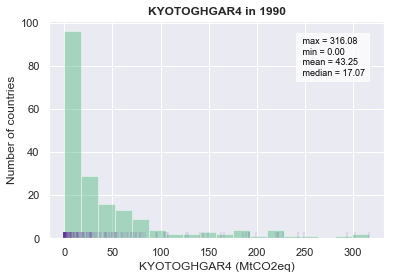

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2000, dtype: float64)
upper outliers are: 
country
Annex I                                                 18454.9018
AUSTRALIA                                                 488.2092
BASIC countries                                          7782.2602
BRAZIL                                                    803.3840
CANADA                                                    735.7543
CHINA                                                    4893.6293
GERMANY                                                  1055.0751
EARTH                       (Whole Table)               34833.5540
SPAIN                                                     393.0953
European Union (28)                                      5229.8633
FRANCE                                                    557.6657
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND      726.3863
INDONESIA                                                 524.

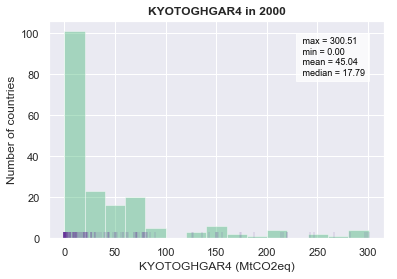

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2015, dtype: float64)
upper outliers are: 
country
Annex I                                                 17403.0245
AUSTRALIA                                                 540.6898
BASIC countries                                         16983.2027
BRAZIL                                                   1074.2409
CANADA                                                    718.0382
CHINA                                                   12610.3507
GERMANY                                                   915.4795
EARTH                       (Whole Table)               46919.9938
European Union (28)                                      4378.7788
FRANCE                                                    467.9575
UNITED KINGDOM OF GREAT BRITAIN AND NORTHERN IRELAND      519.0745
INDONESIA                                                 666.6002
INDIA                                                    2771.

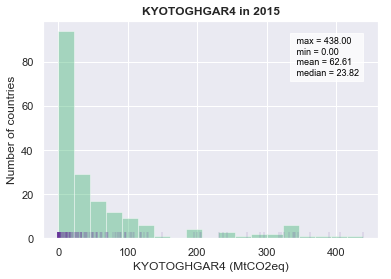

In [155]:
# Plot 1 - make a histogram of absolute data

for selected_year in years_of_interest:
    make_histogram(data_years[selected_year], variable, unit, remove_outliers=True)


Averaging trend over 5 years.
full range is 28.0
bins set to range(-14, 14)


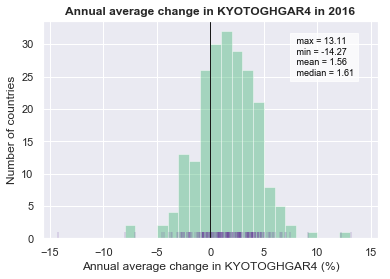

In [161]:
# Plot 2 - trends

def calculate_trends(df, num_years_trend=10): 
    
    # disp average used for trend
    print('Averaging trend over ' + str(num_years_trend) + ' years.')
    
    # calculate annual % changes
    df_perc_change = df.pct_change(axis='columns') * 100
    new_unit = '%'
    
    # average over a window
    df_rolling_average = df_perc_change.rolling(window=num_years_trend, axis='columns').mean()
    
    return df_rolling_average, new_unit

# Calculate trends and define plotting params    
# TODO - improve description here. 
trends_df, trends_unit = calculate_trends(data_years, num_years_trend=5)
trends_variable = 'Annual average change in ' + variable

# plot the trend in the final year
make_histogram(trends_df.iloc[:,-1], trends_variable, trends_unit)


Calculating difference compared to 1990
Calculating difference compared to 2005
---------
All values in the series are the same! Exiting plotting routine for change since 1990 1990
---------
-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2000, dtype: float64)
upper outliers are: 
country
BOLIVIA, THE PLURINATIONAL STATE OF     187.878823
EQUATORIAL GUINEA                      2800.877366
NIGER                                   163.587041
SEYCHELLES                              191.095463
TIMOR-LESTE                             165.045103
Name: 2000, dtype: float64
---
full range is 232.0
bins set to range(-156, 156, 12)


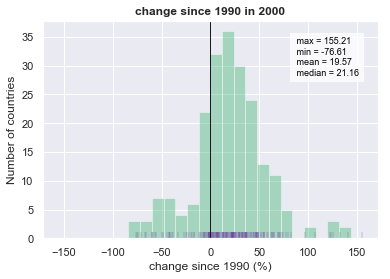

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2015, dtype: float64)
upper outliers are: 
country
UNITED ARAB EMIRATES         460.346214
EQUATORIAL GUINEA           6439.185726
MALDIVES                     548.820503
QATAR                        607.613515
TURKS AND CAICOS ISLANDS     588.322466
Name: 2015, dtype: float64
---
full range is 480.0
bins set to range(-418, 418, 38)


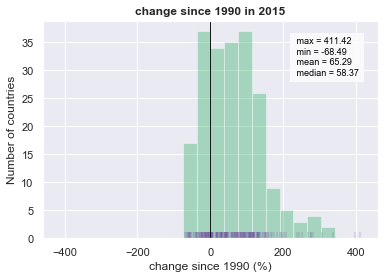

full range is 266.0
bins set to range(-196, 196, 14)


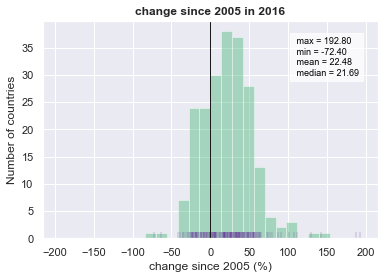

-----------
Identifying and removing outliers
lower outliers are:
Series([], Name: 2016, dtype: float64)
upper outliers are: 
country
NIUE         192.799076
SINGAPORE    187.650706
Name: 2016, dtype: float64
---
full range is 215.0
bins set to range(-147, 147, 14)


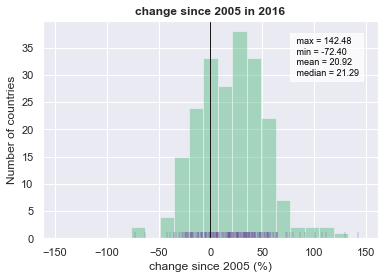

In [169]:
# plot 3 - change since year X

def calculate_diff_since_yearX(df_abs, yearX):
    
    print('Calculating difference compared to ' + yearX)
    
    # first, check that the desired year is in the data!
    if yearX not in df_abs.columns:
        print('The year you have selected for relative calculations ('
               + str(yearX) + ') is not available, please try again.')
        return
    
    
    # calculate all columns relative to the chosen year, first in absolute terms, then %
    df_abs_diff = df_abs.subtract(df_abs[yearX], axis='index')
    #print(df_abs_diff)
    df_perc_diff = 100 * df_abs_diff.divide(df_abs[yearX], axis='index')
    #print(df_perc_diff)
    
    return df_abs_diff, df_perc_diff


# TODO 
# run calculations
df_abs_diff_1990, df_perc_diff_1990 = calculate_diff_since_yearX(data_years, '1990')
df_abs_diff_2005, df_perc_diff_2005 = calculate_diff_since_yearX(data_years, '2005')

# make plots
for selected_year in years_of_interest:
    make_histogram(df_perc_diff_1990[selected_year], "change since 1990", "%", remove_outliers=True)

make_histogram(df_perc_diff_2005.iloc[:,-1], "change since 2005", '%', remove_outliers=False)
make_histogram(df_perc_diff_2005.iloc[:,-1], "change since 2005", '%', remove_outliers=True)
# TODO - this last plot is not symmetroc around 0 - why?


In [124]:
del(temp)
temp

NameError: name 'temp' is not defined